# neural networks in python and numpy!

Let's look at some of the more common neural network concepts and explore the different pros/cons of using each. First, we are going to need some datasets! Let's import numpy and sklearn.

In [1]:
import numpy as np
import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from matplotlib import pyplot as plt

# set this for repeatability (so my comments on the performance make sense!)
np.random.seed(2)

plt.rcParams["figure.figsize"] = (16, 10)

ScienceKit Learn (sklearn) has some great daatsets built in! We can define some functions for loading datasets! 

In [2]:
def get_dataset_iris(test_split=0.20):
    '''returns (x_train, y_train), (x_test, y_test)'''
    dataset = datasets.load_iris()
    X, y = dataset.data, dataset.target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split)
    y_train = one_hot(y_train, 3)
    y_test = one_hot(y_test, 3)
    return (X_train, y_train), (X_test, y_test)

def get_dataset_digits(test_split=0.20):
    '''returns (x_train, y_train), (x_test, y_test)'''
    dataset = datasets.load_digits()
    X, y = dataset.data, dataset.target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split)
    y_train = one_hot(y_train, 10)
    y_test = one_hot(y_test, 10)
    return (X_train, y_train), (X_test, y_test)

def get_dataset_wine(test_split=0.20):
    '''returns (x_train, y_train), (x_test, y_test)'''
    dataset = datasets.load_wine()
    X, y = dataset.data, dataset.target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split)
    y_train = one_hot(y_train, 3)
    y_test = one_hot(y_test, 3)
    return (X_train, y_train), (X_test, y_test)

def one_hot(x, classes):
    '''returns onehot encoded vector for each item in x'''
    ret = []
    for value in x:
        temp = [0. for _ in range(classes)]
        temp[int(value)] = 1.
        ret.append(temp)
    return np.array(ret)

The above functions should be pretty self explainatory, we are loading the datasets and onehot encoding the y (label) values into vectors. This is strictly necesarry for binary classifiers however, all of the datasets have atleast 3 or more different classes.

Let's use our new functions to load up the iris dataset!

In [3]:
# load the iris dataset
(x_train, y_train), (x_test, y_test) = get_dataset_iris()

print('x_train[0]:')
print(x_train[0])

print('y_train[0]:')
print(y_train[0])

x_train[0]:
[6.2 2.8 4.8 1.8]
y_train[0]:
[0. 0. 1.]


Now we have our data loaded up lets look at defining some activation functions for our network to use!

In [4]:
# activation functions and derivatives
def ReLU(x, deriv=False):
    '''returns the Rectified Linear Unit (or derivative) x'''
    if deriv:
        return 1. * (x > 0)
    else:
        x = np.clip(x, -700, 700)
        return x * (x > 0)

def leaky_ReLU(x, deriv=False, alpha=0.1):
    '''returns the leaky Rectified Linear Unit (or derivative) x'''
    if deriv:
        return 1. * (x > 0) + alpha * (x <= 0)
    else:
        x = np.clip(x, -700, 700)
        return x * (x > 0) + x * alpha * (x <= 0)

def ELU(x, deriv=False, alpha=1.0):
    '''returns the Exponential Linear Unit (or derivative) x'''
    if deriv:
        return 1. * (x > 0) + alpha * (np.exp(x)-1) * (x <= 0)
    else:
        x = np.clip(x, -700, 700)
        return x * (x > 0) + alpha * (np.exp(x)-1) * (x <= 0)

def sigmoid(x, deriv=False):
    '''returns the sigmoid (or derivative) x'''
    if deriv:
        return sigmoid(x) * (1 - sigmoid(x))
    else:
        x = np.clip(x, -700, 700)
        return 1 / (1 + np.exp(-x))

def tanh(x, deriv=False):
    '''returns the hyperbolic tangent (or derivative) x'''
    if deriv:
        return 1.0 - (np.tanh(x) ** 2)
    else:
        return np.tanh(x)

Now we have our activation functions lets define our loss function, we will be using a very simple loss function aptly named "absolute loss".

In [5]:
def loss_absolute(y, y_hat):
    return y - y_hat

Let's define one last thing before we build our neural network. A method for spliting the training data batches will allow us to do Batch Gradient Descent. Rather than training our netowkr on one value of x and y at a time, we will be sending through batches! This allows our network to perform much better on most CPU's and also smooths the gradient allowing a "simpler" (and often quicker) descent to the minima!

In [6]:
def split_to_minibatch(z, batch_size=32):
    z_length = len(z)
    current_batch_size = batch_size
    batch_split_points = []
    while current_batch_size < z_length:
        batch_split_points.append(current_batch_size)
        current_batch_size += batch_size
    return np.split(z, batch_split_points)

It's time to build our neural network! we are going to implement an "N-layered Neural Netork", let's define our network as a python class!

In [7]:
class NNN(object):
    """An N-layered neural network"""
    def __init__(self, inputs, weights, outputs, alpha=0.0001, mu=0.9, momentum=False):
        self.inputs = inputs
        self.outputs = outputs
        self._ALPHA = alpha
        self._MU = mu
        self._num_of_weights = len(weights)
        self._LAYER_DEFS = {}
        self.WEIGHT_DATA = {}
        self.BIAS_DATA = {}
        self.enable_momentum = momentum
        if self.enable_momentum:
            self.VELOCITY_DATA = {}
        self.LAYER_FUNC = {}
        self.LAYERS = {}
        for i in range(self._num_of_weights):
            #(in, out, nonlin)
            self._LAYER_DEFS[i] = {'in': weights[i][0],
                                   'out': weights[i][1],
                                   'nonlin': weights[i][2]}
        self._init_layers()
    
    def _init_layers(self):
        for i in range(self._num_of_weights):
            _in = self._LAYER_DEFS[i]['in']
            _out = self._LAYER_DEFS[i]['out']
            _nonlin = self._LAYER_DEFS[i]['nonlin']
            self.WEIGHT_DATA[i] = 2 * np.random.random_sample((_in, _out)) - 1
            self.BIAS_DATA[i] = np.full((1,_out), 0.0)
            if self.enable_momentum:
                self.VELOCITY_DATA[i] = np.zeros(_out)
            self.LAYER_FUNC[i] = _nonlin
    
    def forward_layer(self, prev_layer, next_layer, bias_values, nonlin):
        """Does the actual calcs between layers :)"""
        ret = nonlin(np.dot(prev_layer, next_layer)+bias_values)
        return ret

    def backward_layer(self, w, z, act, prev_delta):
        w_error = prev_delta.dot(w.T)
        cur_delta = w_error * act(z, deriv=True)
        return cur_delta

    def backprop_sgd(self, w, z, act, prev_delta, bias):
        cur_delta = self.backward_layer(w, z, act, prev_delta)
        w += self._ALPHA * z.T.dot(prev_delta)
        bias += -self._ALPHA * np.sum(prev_delta, axis=0, keepdims=True)
        return cur_delta

    def backprop_momentum(self, w, z, act, prev_delta, bias, v):
        cur_delta = self.backward_layer(w, z, act, prev_delta)
        v = self._MU * v + z.T.dot(prev_delta)
        w += self._ALPHA * v
        bias += -self._ALPHA * np.sum(prev_delta, axis=0, keepdims=True)
        return cur_delta
    
    def fit(self, X_in, Y_in, train_loops=100, batch_size=32, quiet=False):
        loss_array = []
        for j in range(train_loops):
            X_in, Y_in = shuffle(X_in, Y_in)
            x_batches = split_to_minibatch(X_in, batch_size)
            y_batches = split_to_minibatch(Y_in, batch_size)
            epoch_loss = 0
            for x, y in zip(x_batches, y_batches):
                # set up layers
                prev_layer = self.LAYERS[0] = x
                for i in range(self._num_of_weights):
                    current_layer = self.forward_layer(prev_layer, 
                                                       self.WEIGHT_DATA[i],
                                                       self.BIAS_DATA[i], 
                                                       self.LAYER_FUNC[i])
                    self.LAYERS[i+1] = current_layer
                    prev_layer = current_layer
                last_layer = current_layer
    
                # calculate errors
                error = loss_absolute(y, last_layer)
                nonlin = self.LAYER_FUNC[self._num_of_weights - 1]
                delta = error * nonlin(last_layer, deriv=True)
    
                epoch_loss += np.sum(abs(error))
    
                prev_delta = delta
                for i in reversed(range(self._num_of_weights)):
                    if self.enable_momentum:
                        prev_delta = self.backprop_momentum(self.WEIGHT_DATA[i],
                                                            self.LAYERS[i], 
                                                            self.LAYER_FUNC[i], 
                                                            prev_delta, 
                                                            self.BIAS_DATA[i],
                                                            self.VELOCITY_DATA[i])
                    else:
                        prev_delta = self.backprop_sgd(self.WEIGHT_DATA[i],
                                                       self.LAYERS[i], 
                                                       self.LAYER_FUNC[i], 
                                                       prev_delta, 
                                                       self.BIAS_DATA[i])
            
            loss_array.append(epoch_loss)
            
            if not quiet:
                if (j % (train_loops/10)) == 0:             
                    print("-"*32)
                    print("loop: {}".format(j))
                    print("-"*32)
                    print("Guess (rounded): \n{}".format(np.round(last_layer[0], 3)))
                    print("Actual: \n{}".format(np.round(y[0], 3)))
                    print("-"*32, '\n')

        return loss_array
        
    def evaluate(self, x, y):
        # set up layers
        prev_layer = self.LAYERS[0] = x
        for i in range(self._num_of_weights):
            current_layer = self.forward_layer(prev_layer, 
                                               self.WEIGHT_DATA[i],
                                               self.BIAS_DATA[i], 
                                               self.LAYER_FUNC[i])
            self.LAYERS[i+1] = current_layer
            prev_layer = current_layer
        last_layer = current_layer
        error = loss_absolute(y, last_layer)
        total_error = np.sum(abs(error))
        return total_error

Ok! Let's test out our network using the sigmoid activation function!

Training with batch size: 1
Total loss after training: 1.9795368075705906
Training with batch size: 8
Total loss after training: 2.5126665560183126
Training with batch size: 16
Total loss after training: 1.2890433143018925
Training with batch size: 32
Total loss after training: 3.0687015104660103
Training with batch size: 64
Total loss after training: 2.5887010011777787
Effect of batch sizes on training


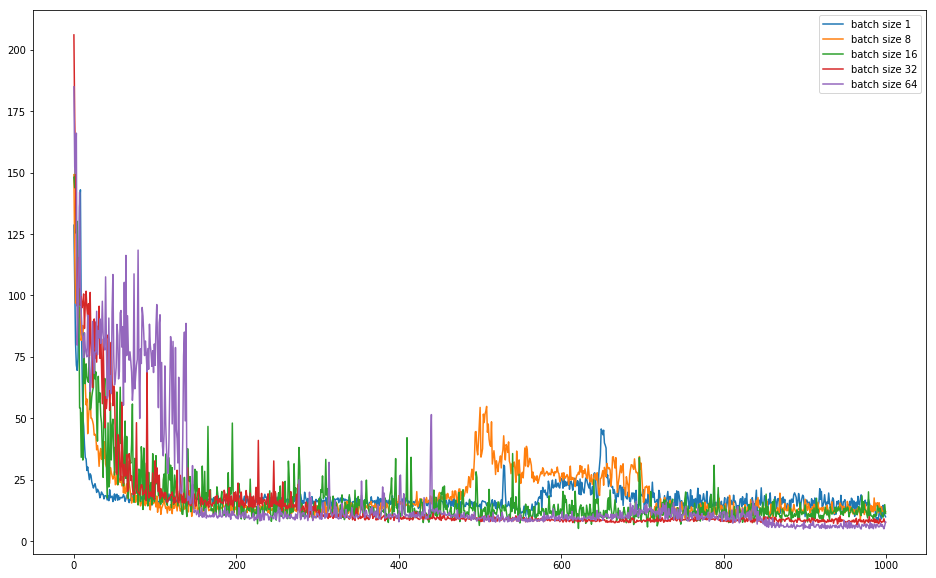

In [10]:
# setup number of inputs/outputs for the given dataset
i_input = len(x_train[0])
i_out = len(y_train[0])

# define our layers
# (in size, out size, activation function)
layers = ((i_input, 32, ELU),
          (32, 16, ELU),
          (16, 8, ELU),
          (8, i_out, sigmoid))

# define how many training epochs
train_epochs = 1000

# define the training batch size
batch_sizes = [1, 8, 16, 32, 64]

# set our alpha (or learning rate)
alpha = 0.005

results = {}

for batch_size in batch_sizes:
    nn = NNN(i_input, layers, i_out, alpha)

    print('Training with batch size: {}'.format(batch_size))
    results[batch_size] = nn.fit(x_train, y_train, train_epochs, batch_size, quiet=True)

    total_loss = nn.evaluate(x_test, y_test)
    print('Total loss after training: {}'.format(total_loss))

def graph_loss(losses, epochs, names=None):
    x = [x for x in range(epochs)]
    plt.xlabel = 'Epochs'
    plt.ylabel = 'error'
    plot_args = []
    for i, y in enumerate(losses):
        if names:
            plt.plot(x, y, label=names[i])
        else:
            plt.plot(x, y)
    plt.legend()
    plt.show()

print('Effect of batch sizes on training')
names = ['batch size {}'.format(x) for x in batch_sizes]
losses = [results[key] for key in batch_sizes]
graph_loss(losses, train_epochs, names)
